In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_pred = pd.read_csv("c3_model_predictions.csv")
df_pred.head()

,y_true,y_pred_lr,y_pred_hub,y_pred_dt,y_pred_rf,y_pred_knn,species
0,3250.0,3186.613981,3190.888090,3175.0,3195.50,3273.112286,Adelie
1,4875.0,4929.282706,4928.207019,4400.0,4872.25,4971.757801,Gentoo
2,4000.0,4061.310494,4043.939336,4250.0,4177.00,4124.402577,Adelie
3,3675.0,3519.998625,3549.329730,3950.0,3759.75,3507.845984,Chinstrap
4,4050.0,3934.843283,3910.346362,3900.0,3939.75,4001.459647,Adelie


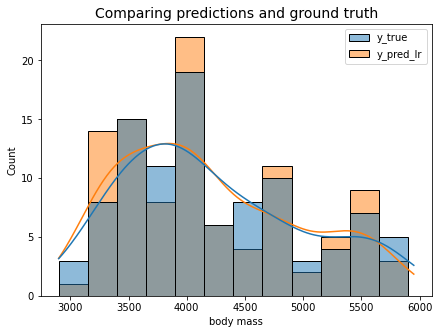

In [3]:
# filter data
y_true = df_pred.y_true
y_pred_lr = df_pred.y_pred_lr

# setup bins of width 250g
y_min, y_max = y_true.min(), y_true.max()
bins = np.arange(y_min, y_max, 250)

# plot histogram
plt.figure(figsize=(7, 5))
sns.histplot(data=df_pred.loc[:,["y_true", "y_pred_lr"]], bins=bins, kde=True)

# add titles and labels
plt.title("Comparing predictions and ground truth", fontsize=14)
plt.xlabel("body mass")
plt.show()

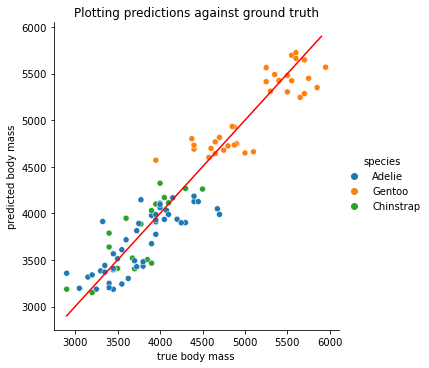

In [4]:
# plot scatterplot
sns.relplot(x=y_true, y=y_pred_lr, hue=df_pred.species, height=5)

# plot diagonal line
line_x = np.arange(y_min, y_max, 100)
plt.plot(line_x, line_x, c="r")

# add title and labels
plt.title("Plotting predictions against ground truth")
plt.xlabel("true body mass")
plt.ylabel("predicted body mass")
plt.show()

For linear models, the first three scenarios (underestimate below the line, over above the line, under light bird over heavier bird) might have arisen due to outliers in the training data. The final scenario (errors increase as body weight increases) might arise if target values are skewed, and hence the target would benefit from a transformation before training models.

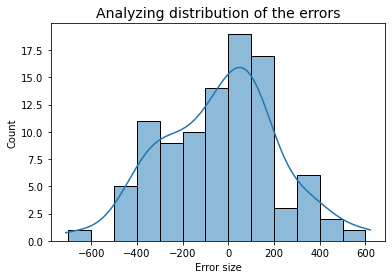

In [5]:
# common assumption that distribution of the "noise" ie errors are approx normally distributed

# calculate error 
errors = y_pred_lr - y_true

# plot histo with bins of 100g
sns.histplot(x=errors, bins=np.arange(-700, 700, 100), kde=True)
plt.title("Analyzing distribution of the errors", fontsize=14)
plt.xlabel("Error size")
plt.show()

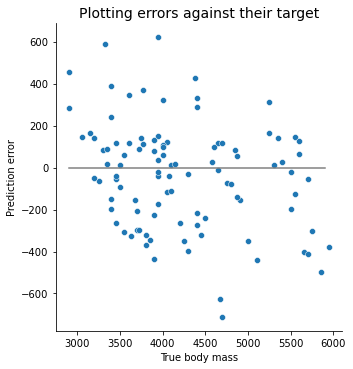

In [6]:
# plot errors directly against true target

# plot scatter plot 
sns.relplot(x=y_true, y=errors, height=5)

# for horizontal line
y_min, y_max = y_true.min(), y_true.max()
line_x = np.arange(y_min, y_max, 100)
plt.plot(line_x, 0 * line_x, c="gray")

# add title and labels
plt.title("Plotting errors against their target", fontsize=14)
plt.xlabel("True body mass")
plt.ylabel("Prediction error")
plt.show()

no obvious trend


Now compare model to model

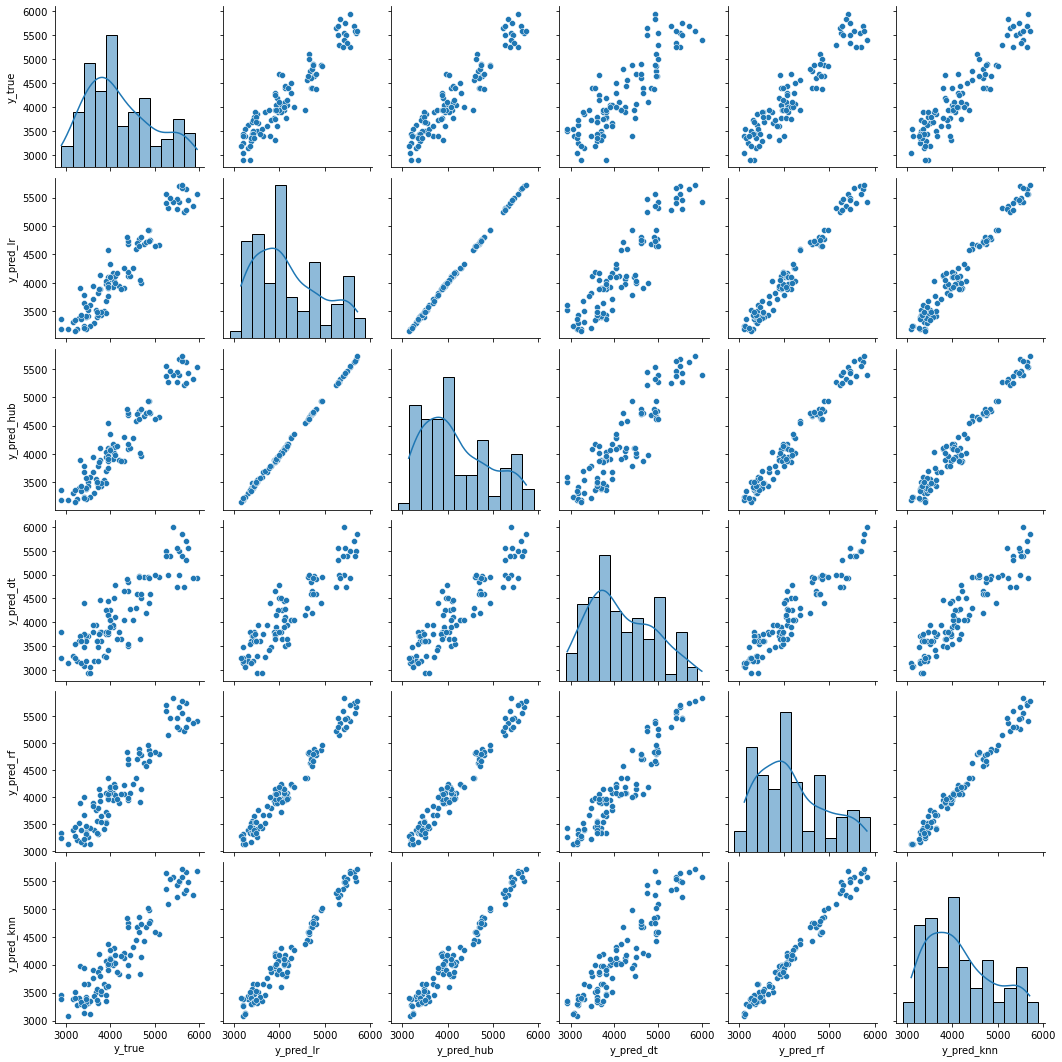

In [7]:
# setup bins width 250g
bins = np.arange(y_min, y_max, 250)
sns.pairplot(
    df_pred,
    diag_kws={"bins": bins, "kde": True},
)
plt.show()

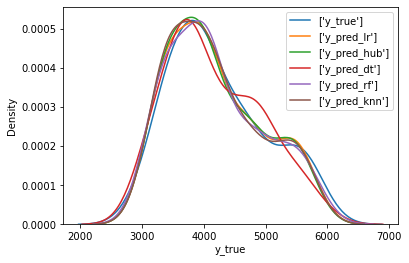

In [9]:
for c in df_pred.columns[df_pred.columns.str.contains("y_")]:
    sns.kdeplot(df_pred[c], label=[c])

plt.legend()
plt.show()

decision tree only model that doesnt fit well

Comparing model predictions sample by sample

In [10]:
df_pred2 = df_pred.sort_values("y_true").reset_index(drop=False)
# We retain the original index so we can easily identify the original samples whenever necessary.

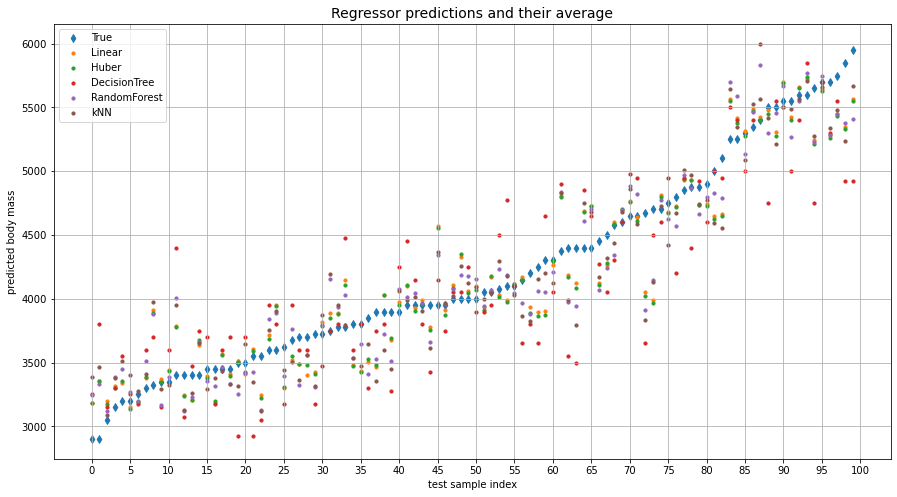

In [11]:
# Setup
plt.figure(figsize=(15, 8))
ind = df_pred.index
s = 10

# Plots
plt.scatter(ind, df_pred2.y_true, color="C0", marker="d", s=3 * s, label="True")
plt.scatter(ind, df_pred2.y_pred_lr, color="C1", s=s, label="Linear")
plt.scatter(ind, df_pred2.y_pred_hub, color="C2", s=s, label="Huber")
plt.scatter(ind, df_pred2.y_pred_dt, color="C3", s=s, label="DecisionTree")
plt.scatter(ind, df_pred2.y_pred_rf, color="C4", s=s, label="RandomForest")
plt.scatter(ind, df_pred2.y_pred_knn, color="C5", s=s, label="kNN")

# Add title, labels, etc.
plt.title("Regressor predictions and their average", fontsize=14)
plt.xlabel("test sample index")
plt.ylabel("predicted body mass")

plt.grid(True)
plt.xticks(ticks=np.arange(0, 101, 5))
plt.legend(loc="best")

plt.show()

Samples with very similar target values for which predictions amongst vary (41-50 & 61-65)

In [12]:
# select best 4 models
df_best_4 = df_pred2.loc[
    :, ["y_pred_lr", "y_pred_hub", "y_pred_rf", "y_pred_knn"]
].copy()

# Calculating the prediction errors and calculating their stats per sample
df_best_4_errors = df_best_4.subtract(df_pred2.y_true, axis=0)
df_best_4_avg_errors = df_best_4_errors.mean(axis=1)
df_best_4_avg_errors.name = "avg error"
df_best_4_std_errors = df_best_4_errors.std(axis=1)
df_best_4_std_errors.name = "std error"

In [13]:
# samples with best average prediction

np.abs(df_best_4_avg_errors).sort_values().to_frame().head()

,avg error
43,4.430238
92,9.909463
71,14.755152
54,18.176192
46,21.680598


In [14]:
# samples with strongest average underestimation

df_best_4_avg_errors.sort_values().to_frame().head()

,avg error
72,-721.508580
73,-640.974457
98,-526.396622
37,-441.309766
82,-437.330235


In [15]:
# samples with strongest average overestimation

df_best_4_avg_errors.sort_values(ascending=False).to_frame().head()

,avg error
8,589.645929
45,509.021195
11,480.330710
1,475.870630
61,442.219984


In [16]:
# best agreement
df_best_4_std_errors.sort_values().to_frame().head()

,std error
69,9.338461
14,14.949520
97,18.366187
61,20.777373
65,22.653241


In [17]:
# worst agreement
df_best_4_std_errors.sort_values(ascending=False).to_frame().head()


,std error
38,220.142656
87,196.083355
31,175.323321
33,158.690470
59,151.524435


decide the winner..

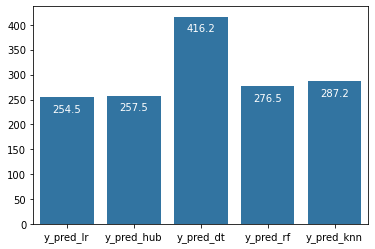

In [18]:
from sklearn.metrics import mean_squared_error

# Get the column names
trained_models = list(df_pred)[1:-1]

# Calculate the RMSE per model
rmse_list = []
for model in trained_models:
    model_rmse = mean_squared_error(df_pred["y_true"], df_pred[model], squared=False)
    # Note squared=False returns RMSE instead of MSE
    rmse_list.append(np.round(model_rmse, 1))

# The plot
sns.barplot(x=trained_models, y=rmse_list, color="C0")
# Add the RMSE values as labels to each bar
for i in range(len(rmse_list)):
    plt.text(
        x=i,  # the horizontal position, i.e. the ith bar
        y=rmse_list[i] - 30,  # the vertical position
        s=rmse_list[i],  # the text
        color="white",
        horizontalalignment="center",
    )
plt.show()